In [1]:
import torch
from torch import nn,optim
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.utils.data import DataLoader 
from torch.utils.data.sampler import SubsetRandomSampler
from statistics import mean
import matplotlib.pyplot as plt

In [2]:
folder_path = '/Users/gursi/Desktop/ML_other/other_projects/face_rec/face_rec_dataset'
transforms = transforms.Compose([transforms.Resize(256), transforms.CenterCrop(256), transforms.ToTensor()])
train = ImageFolder(folder_path, transform=transforms)
labelmap = train.class_to_idx
print(train)
print(labelmap)

Dataset ImageFolder
    Number of datapoints: 10627
    Root location: /Users/gursi/Desktop/ML_other/other_projects/face_rec/face_rec_dataset
    StandardTransform
Transform: Compose(
               Resize(size=256, interpolation=PIL.Image.BILINEAR)
               CenterCrop(size=(256, 256))
               ToTensor()
           )
{'me': 0, 'not_me': 1}


In [3]:
class NET(nn.Module):

    def __init__(self, out1=32, out2=64, n1=64, n2=32):
        super(NET,self).__init__()

        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=out1, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 1)
        )

        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=out1, out_channels=out2, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 4, stride = 2)
        )

        self.fc1 = nn.Sequential(
            nn.Linear(out2 * 30 * 30, n1),
            nn.BatchNorm1d(n1),
            nn.ReLU()
        )

        self.fc2 = nn.Sequential(
            nn.Linear(n1, n2),
            nn.BatchNorm1d(n2),
            nn.ReLU()
        )

        self.output = nn.Linear(n2,2)

    def forward(self,x):
        x = self.convblock1(x)
        x = self.convblock2(x)

        x = x.view(x.shape[0], x.shape[1] * x.shape[2] * x.shape[3])

        x = self.fc1(x)
        x = self.fc2(x)
        x = self.output(x)
        return x

In [4]:
def train_model(model, opt, criterion, epochs, train_loader, test_loader, dataset_size, batch_size):

    stats_dict = {'all_loss':[], 'mean_loss':[], 'accuracy':[], 'models':[]}
    num_batches = int(dataset_size/batch_size)
    print(num_batches, 'batches per epoch.')

    try : 
        for epoch in range(epochs):
        
            print(f'EPOCH {epoch+1}')
            print()
            
            batch_counter = 0
            mean_loss_for_epoch = []

            for x,y in train_loader :

                if batch_counter % 1 == 0 :
                    print(str(batch_counter) + ' --> ', end = '', flush = True)

                model.train()
                opt.zero_grad()

                yhat = model.forward(x)
                loss = criterion(yhat,y)

                stats_dict['all_loss'].append(loss.item())
                mean_loss_for_epoch.append(loss.item())

                loss.backward()
                opt.step()
                batch_counter += 1

            stats_dict['mean_loss'].append(mean(mean_loss_for_epoch))
            stats_dict['models'].append(model)
            print()
            print('Mean loss for epoch :', mean(mean_loss_for_epoch))

            correct = 0
            incorrect = 0
            for x,y in test_loader :

                model.eval()
                yhat = model.forward(x)

                for i in range(len(yhat)) : 
                    if torch.argmax(yhat[i]) == y[i] :
                        correct += 1
                    else :
                        incorrect += 1

            acc = (correct / (incorrect + correct)) * 100
            print('Accuracy on test set : ', acc, '%')
            stats_dict['accuracy'].append(acc)
            print('-' * 50)

        return stats_dict

    except :
        return stats_dict

In [5]:
#net = NET()
net = torch.load('facerec_model.pt')
print(net)

NET(
  (convblock1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
  )
  (convblock2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=4, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Sequential(
    (0): Linear(in_features=57600, out_features=64, bias=True)
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (fc2): Sequential(
    (0): Linear(in_features=64, out_features=32, bias=True)
    (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (output): Linear(in_features=32, out_features=2, bias=True)
)


In [6]:
BATCH_SIZE = 100
DATASET_SIZE = len(train)
LR = 0.001
EPOCHS = 10
SAMPLE_SIZE = DATASET_SIZE
TEST_SIZE = 5000

train_indices = torch.randperm(DATASET_SIZE)[:SAMPLE_SIZE]
train_loader = DataLoader(dataset = train, batch_size = BATCH_SIZE, sampler = SubsetRandomSampler(train_indices))
test_indices = torch.randperm(DATASET_SIZE)[:TEST_SIZE]
test_loader = DataLoader(dataset = train, batch_size = TEST_SIZE, sampler = SubsetRandomSampler(test_indices))

#train_loader = DataLoader(dataset = train, batch_size = BATCH_SIZE, shuffle = True)
#test_loader = DataLoader(dataset = train[:TEST_SIZE], batch_size = TEST_SIZE, shuffle = True)

criterion = nn.CrossEntropyLoss()
opt = optim.SGD(net.parameters(), lr=LR)

stats = train_model(net, opt, criterion, EPOCHS, train_loader, test_loader, SAMPLE_SIZE, BATCH_SIZE)

106 batches per epoch.
EPOCH 1

0 --> 1 --> 2 --> 3 --> 4 --> 5 --> 6 --> 7 --> 8 --> 9 --> 10 --> 11 --> 12 --> 13 --> 14 --> 15 --> 16 --> 17 --> 18 --> 19 --> 20 --> 21 --> 22 --> 23 --> 24 --> 25 --> 26 --> 27 --> 28 --> 29 --> 30 --> 31 --> 32 --> 33 --> 34 --> 35 --> 36 --> 37 --> 38 --> 39 --> 40 --> 41 --> 42 --> 43 --> 44 --> 45 --> 46 --> 47 --> 48 --> 49 --> 50 --> 51 --> 52 --> 53 --> 54 --> 55 --> 56 --> 57 --> 58 --> 59 --> 60 --> 61 --> 62 --> 63 --> 64 --> 65 --> 66 --> 67 --> 68 --> 69 --> 70 --> 71 --> 72 --> 73 --> 74 --> 75 --> 76 --> 77 --> 78 --> 79 --> 80 --> 81 --> 82 --> 83 --> 84 --> 85 --> 86 --> 87 --> 88 --> 89 --> 90 --> 91 --> 92 --> 93 --> 94 --> 95 --> 96 --> 97 --> 98 --> 99 --> 100 --> 101 --> 102 --> 103 --> 104 --> 105 --> 106 --> 
Mean loss for epoch : 0.1673421489301129
Accuracy on test set :  98.36 %
--------------------------------------------------
EPOCH 2

0 --> 1 --> 2 --> 3 --> 4 --> 5 --> 6 --> 7 --> 8 --> 9 --> 10 --> 11 --> 12 --> 13 --> 

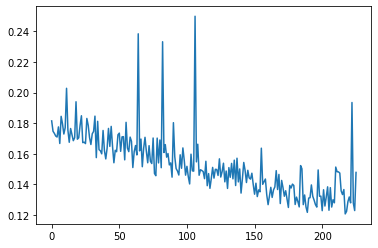

In [7]:
plt.plot(stats['all_loss'])

In [8]:
torch.save(net, 'facerec_model.pt')